### $\color{indianred}{\text{ДОДАТНА ВЈЕЖБА ИЗ АСТРОСТАТИСТИКЕ (v1)}} $

### Апроксимација функције ($\sin{x}$) користећи PyTorch

У вјежби су генерисани тренинг и тест скупови података. Дефинисана је базична неурална

мрежа. Модел је трениран и евалуиран на крају. Додат је и дио са регуларизацијом.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.manual_seed(42) # репродуцибилност
np.random.seed(42) 

In [3]:
def exact_solution(x): # тачно рјешење
    return torch.sin(x)

### 1. Генерисање података

<hr style="border: none; height: 2px; background-color: red; opacity: 0.5;" />

Користи се сљедећи скуп података за тренинг:

$$
\mathcal{S} = \{(x_i, u_i), \ i = 1, \dots, n \},
$$

гдје важи:
$$
x_i \sim \mathcal{U}(0, 2\pi), \quad u_i \sim \mathcal{N}(\sin(x_i), \sigma(x_i)).
$$

Имамо униформну и нормалну расподјелу. Вриједности $x_i$ се узоркују из униформне, а вриједности $u_i$

из нормалне расподјеле (средња вриједност и стандардна девијација су јасно одређене).


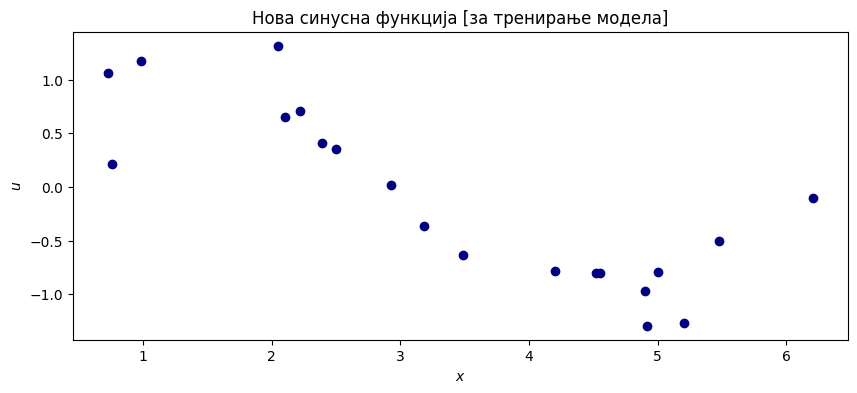

In [4]:
opt_type = "ADAM" # Adaptive Moment Estimation
sampling_seed = 78
torch.manual_seed(sampling_seed)

n_samples = 20 # број тренинг узорака (координата)
sigma = 0.25 # шум

x = 2 * np.pi * torch.rand((n_samples, 1))
y = exact_solution(x) + sigma * torch.randn(x.shape) # подаци су сада реалистичнији

batch_size = 5 # подаци се обрађују у групама
training_set = DataLoader(torch.utils.data.TensorDataset(x, y), batch_size=batch_size, shuffle=True) 

plt.figure(figsize=(10,4))
plt.scatter(x.detach(), y, c='navy')
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.title(r'Нова синусна функција [за тренирање модела]')
plt.show()

*ADAM* је оптимизациони алгоритам, који рачуна индивидуалне стопе учења код различитих параметара,

а из процјена првог и другог момента градијента. Рачунски је ефикасан.

---

### 2. Дефинисање модела

<hr style="border: none; height: 2px; background-color: red; opacity: 0.5;" />

Користимо вишеслојни *перцептрон* да апроксимирамо функцију $u = \sin(x)$. Ово се још назива

и *feedforward neural network* (користићемо *НМ*). Учитавају се вриједности $x\in D\subset\mathbb{R^n}$, које

се кроз НМ трансформишу у $u_{\theta}(x)\in\mathbb{R^m}$, кроз слој неурона, што резултује репрезентацијом:

$$
u_\theta(x) = C_K \circ A \circ C_{K-1} \circ \cdots \circ C_2 \circ A \circ C_1(x).
$$

Наравно, ознака $\circ$ је композиција функција, а $A$ је скаларна (нелинеарна) активациона функција. 

$A$ је често дато као ReLu (*Rectified Linear Unit*) или сигмоидна функција. Ознака $C_K$ односи се на

сукцесивне трансформације (линеарне [нпр. множење матрица] или нелинеарне операције).


За $1\leq k \leq K$ (гдје је $k$ слој), може се дефинисати:

$$
C_k z_k = W_k z_{k-1} + b_k, \quad \text{за} \quad W_k \in \mathbb{R}^{d_{k+1} \times d_k}, \quad z_k \in \mathbb{R}^{d_k}, \quad b_k \in \mathbb{R}^{d_{k+1}}.
$$

За $k$-ти слој, $W_k$ је матрица отежењености, $b_k$ је фактор пристрасности, учитава се $z_{k-1}$, а враћа

се $z_k$. Такође, имамо тотални скуп параметара који се могу тренирати:

$$
\theta = \{W_k, b_k\}, \quad \theta_w = \{W_k\} \quad \forall 1 \leq k \leq K,
$$

Другим ријечима, имамо подесиве отежењености за НН. Дакле, циљ је да НН научи синусну функцију. 

Кроз тренинг, долази се до оптималних отежењености и пристрасности.

In [5]:
class NeuralNet(nn.Module): # НН

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__() # валидан PyTorch модел
        self.input_dimension = input_dimension # број димензија за учитавање (n)
        self.output_dimension = output_dimension # број димензија за враћање (m)
        self.neurons = neurons # број неурона по слоју
        self.n_hidden_layers = n_hidden_layers # број скривених слојева
        self.activation = nn.Tanh() # активациона функција (тангенс хиперболички)
        
        if self.n_hidden_layers != 0: # вишеслојна мрежа
            self.input_layer = nn.Linear(self.input_dimension, self.neurons) # први слој
            self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) # листа скривених слојева
                 for _ in range(n_hidden_layers-1)])
            self.output_layer = nn.Linear(self.neurons, self.output_dimension) # коначни слој

        else:
            print('Проста линеарна регресија') # директно мапирање између учитаних и враћених ствари
            self.linear_regression_layer = nn.Linear(
                self.input_dimension, self.output_dimension)

    def forward(self, x): # трансформације које дефинишу НН
        if self.n_hidden_layers != 0:
            x = self.activation(self.input_layer(x)) # примјена активационе функције
            for k, l in enumerate(self.hidden_layers): # за сваки скривени слој, примјењује се акт. функција
                x = self.activation(l(x))
            return self.output_layer(x)
        else:
            return self.linear_regression_layer(x)

def NeuralNet_Seq(input_dimension, output_dimension, n_hidden_layers, neurons): ## НН, концизније
    modules = list()
    modules.append(nn.Linear(input_dimension, neurons))
    modules.append(nn.Tanh())
    for _ in range(n_hidden_layers):
        modules.append(nn.Linear(neurons, neurons))
        modules.append(nn.Tanh())
    modules.append(nn.Linear(neurons, output_dimension))
    model =  nn.Sequential(*modules)
    return model

Изнад су понуђена два начина за прављење НН. *NeuralNet* и *NeuralNet_Seq* се разликују у

спецификацији слојева. Класа *NeuralNet* има више флексибилности. Лакше је подесити НН и 

може се прећи на сложеније примјере (модификација слојева, друге активационе функције и сл.),

док је *NeuralNet_Seq* функција једноставнији начин да се направи НН.

In [6]:
my_network = NeuralNet( # дефинисање модела
    input_dimension = x.shape[1],
    output_dimension = y.shape[1],
    n_hidden_layers=2,
    neurons=20)

# u_pred = my_network(x) # предвиђања
# u_ex = exact_solution(x) # тачно рјешење
# print(u_pred, u_ex)
# my_network = NeuralNet_Seq(input_dimension=x.shape[1], output_dimension=y.shape[1], 
                                # n_hidden_layers=1, neurons=20) # алтернатива

Иницијализација параметара отежењености је битан међукорак, због тога што је потребно нивелисати

градијенте на прави начин (учење треба бити лако и брзо). Обично се користи *Xavier* иницијализација:

$$
W_k \sim \mathcal{N}(0, \sigma_W^k), \quad \sigma_W^k = g \sqrt{\frac{2}{d_k + d_{k+1}}},
$$

гдје су отежењености дефинисане преко нормалне расподјеле (средња вриједност $0$, а стандардна 

девијација $\sigma_W^k$). Параметар $g$ је фактор скалирања ($g=1$ за $\tanh$, $g=\sqrt{2}$ за ReLU функцију активације).

Ознака $d_k$ је број неурона у претходном слоју, а ознака $d_{k+1}$ је број неурона у садашњем слоју. 

Иницијализација отежењености може се одрадити и преко униформне расподјеле (исто *Xavier*):

$$
W_k \sim \mathcal{U}(-l_k^W, l_k^W), \quad l_k^W = g \sqrt{\frac{6}{d_k + d_{k+1}}},
$$

гдје су $-l_k^W, l_k^W$ границе интервала. 

In [7]:
def init_xavier(model, retrain_seed): # иницијализација отежењености
    torch.manual_seed(retrain_seed) # репродуцибилност
    def init_weights(m): # помоћна функција
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad: # могућност тренирања
            g = nn.init.calculate_gain('tanh') #  фактор скалирања
            torch.nn.init.xavier_uniform_(m.weight, gain=g) # xavier униформна расподјела
            # torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0) # пристрасности
    model.apply(init_weights) # примјена на сваки слој

retrain = 1456
init_xavier(my_network, retrain) # иницијализација уз репродуцибилност
print(my_network(x)) # предвиђања

tensor([[2.4351],
        [2.0060],
        [2.4279],
        [2.5236],
        [2.5071],
        [2.5291],
        [2.5168],
        [2.4510],
        [1.7129],
        [2.5296],
        [2.5319],
        [2.4689],
        [2.5215],
        [2.4845],
        [1.7582],
        [2.4788],
        [2.5094],
        [2.5261],
        [2.5233],
        [2.5177]], grad_fn=<AddmmBackward0>)


---

Оваква иницијализација отежењености гарантује да је варијанса варијабли константна, док се 

учитани параметри преносе даље кроз мрежу.

### 3. Тренирање модела

<hr style="border: none; height: 2px; background-color: red; opacity: 0.5;" />

Неурална мрежа $u_{\theta}$ зависи од финог подешавања параметара $\theta \in \Theta$ (отежењености и пристрасности). 

Стандардно, мрежа се тренира налажењем параметара $\theta$, тако да је функција губитка $Ј(\theta)$ минимизована:


$$
\theta^* \in \Theta : \theta^* = \arg \min_{\theta \in \Theta} J(\theta).
$$

Функција губитка може бити нпр. средња квадратна грешка између предвиђања неуралне мреже и рјешења:

$$
J(\theta) = \sum_i (u_i - u_\theta(x_i))^2.
$$

У пракси, тренирање се ради коришћењем мини-серија (дијелова) података $\mathcal{S}_j$:
$$
J_s(\theta) = \sum_{x_i \in \mathcal{S}_j} (u_i - u_\theta(x_i))^2.
$$

Да би се ажурирали параметри $\theta$, рачуна се градијент функције губитка:

$$
\nabla_\theta J_s(\theta).
$$

Оптимизатор (нпр. горепоменути *ADAM*) користи ову информацију да прилагоди параметре, тако да губитак

буде што мањи. Ажурирање параметара се врши преко:

$$
\theta_{k+1} = \theta_k - \eta \nabla_\theta J_s(\theta_k),
$$

гдје је $\theta_k$ скуп параметара на итерацији $k$, а стопа учења је $\eta$. Процес се понавља за много итерација (епоха), 

све док мрежа не конвергира ка скупу параметара који минимизују губитак. Важи $k = 1, \dots, (n_{\text{epoch}} \times n_{\text{batch}})$.

In [8]:
if opt_type == 'ADAM':
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001) # lr је стопа учења
elif opt_type == 'LBFGS':
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, 
                             tolerance_change=1.0 * np.finfo(float).eps) # испод објашњење
else:
    raise ValueError('Непознати оптимизатор')

*LBFGS* оптимизатор је заправо квази-Њутнов метод. Ако имамо неку генеричку функцију $f : x \mapsto f(x),\,x \in \mathbb{R}^d,$

$f(x) \in \mathbb{R}$, Тејлорова апроксимација за $\nabla f$ у околини $x_k$ биће дата као:

$$
\nabla f(x_k + \delta x) = \nabla f(x_k) + H_k \delta x,
$$

гдје је $H_k$ Хесијан од $f$ за $x_k$. Тражи се $\delta x$ тако да:

$$
\nabla f(x_k + \delta x) = 0.
$$

Ово води до Њутновог метода:

$$
x_{k+1} = x_k - H_k^{-1} \nabla f.
$$

Апроксимацијом Хесијана позитивно дефинитном матрицом $B$, добија се квази-Њутнов метод:
$$
x_{k+1} = x_k - B_k^{-1} \nabla f.
$$

Матрицу $B$ је лакше рачунати, а важи и сљедећа једнакост:

$$
B_{k+1}[x_{k+1} - x_k] = \nabla f(x_{k+1}) - \nabla f(x_k).
$$

*LBFGS* је доста спорији од методе *ADAM*, али је обично прецизнији.

In [9]:
def fit(model, training_set, num_epochs, optimizer, p, verbose=True): # p-експонент за контролу грешке
    history = list() # историја за тренинг
    
    # петља за епохе
    for epoch in range(num_epochs):
        if verbose: print("## ", epoch, " ##")

        running_loss = list([0])

        # петља за мини-серије
        for j, (x_train_, u_train_) in enumerate(training_set):  
            
            def closure(): # губици и градијенти
                optimizer.zero_grad() # чишћење градијената из претходне итерације
                u_pred_ = model(x_train_) # предвиђања за тренутну мини-серију
                loss = torch.mean((u_pred_.reshape(-1, ) - u_train_.reshape(-1, ))**p) # функција губитка 
                loss.backward() # градијенти губитака
                running_loss[0] += loss.item() # акумулирање губитака
                # for param in model.parameters():
                #    print(param.shape)
                #    print(param.grad)
                return loss
                
            optimizer.step(closure=closure) # оптимизатор (губитак, тзв. backpropagation и ажурирање)
            
        if verbose: print('Губитак: ', (running_loss[0] / len(training_set))) # праћење напретка тренинга
        history.append(running_loss[0])

    return history

**Можемо да кренемо у тренирање мреже :)**

In [10]:
n_epochs = 2000
history = fit(my_network, training_set, n_epochs, optimizer_, p=2, verbose=False) # поставити verbose=True

### 4. Евалуација модела

<hr style="border: none; height: 2px; background-color: red; opacity: 0.5;" />

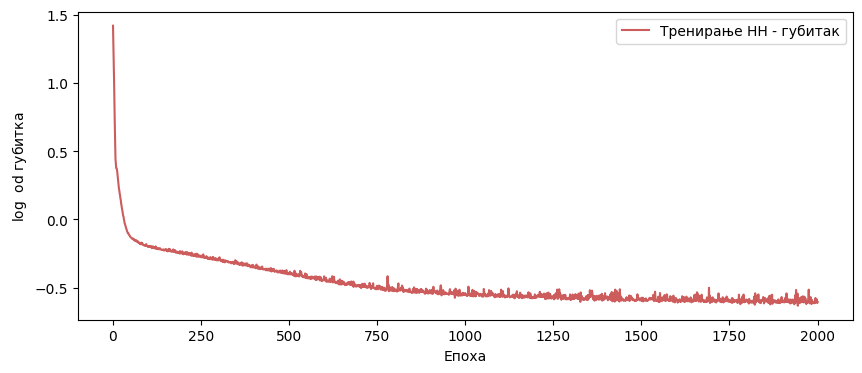

In [11]:
plt.figure(figsize=(10,4))
plt.plot(np.arange(1, n_epochs + 1), np.log10(history), c='indianred', label='Тренирање НН - губитак')
plt.legend()
plt.xlabel(r'Епоха') 
plt.ylabel(r'$\text{log}$  od губитка') 
plt.show()

Коначно, упоређујемо резултате добијене из НН са правом функцијом.

In [12]:
x_test = torch.linspace(0, 2*np.pi, 10000).reshape(-1,1) # учитани подаци
y_test = exact_solution(x_test).reshape(-1) # праве вриједности
y_test_pred = my_network(x_test).reshape(-1) # НН предвиђене вриједности 

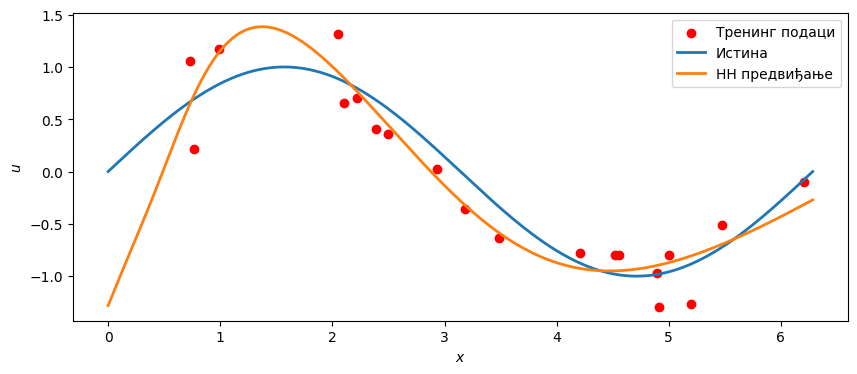

In [13]:
plt.figure(figsize=(10,4))
plt.scatter(x, y, label='Тренинг подаци', marker='o', color='red')
plt.plot(x_test, y_test, label='Истина', lw=2)
plt.plot(x_test, y_test_pred.detach(), label='НН предвиђање', lw=2)
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
plt.legend()
plt.show()

In [14]:
relative_error_test = torch.mean((y_test_pred - y_test) ** 2)/torch.mean(y_test ** 2)
print('Релативна грешка теста: ', relative_error_test.detach().numpy() * 100, "%")

Релативна грешка теста:  20.75600177049637 %


---

Битно је нагласити да могућности модела варирају у зависности од вриједности које су узете за 

$\sigma$ и $n_{\text{samples}}$. Нпр. за велике вриједности $\sigma$ и мале вриједности $n_{\text{samples}}$, долази до претјераног

фитовања, те опада способност генерализације модела. Ово се може ублажити регуларизацијом:

$$
\theta^* = \arg \min_{\theta \in \Theta} \left( J(\theta) + \lambda_{\text{reg}} J_{\text{reg}}(\theta) \right),
$$

гдје је $J_{\text{reg}}:\Theta\mapsto \mathbb{R}$ регуларизациони члан. За регуларизациони параметар важи $0\leq\lambda_{\text{reg}}\ll1$.

In [16]:
def regularization(model, order): # примјер за регуларизациону функцију
    reg_loss = 0
    for name, param in model.named_parameters():
        if 'weight' in name or 'bias' in name:
            reg_loss = reg_loss + torch.norm(param, order)
    return reg_loss